In [37]:
ls

benchmark.15.25.50.45.0.01.100.600.json  benchmark.5.5.15.15.0.01.100.600.log
benchmark.25.30.50.45.0.01.100.600.json  benchmark.py*
benchmark.25.30.50.45.0.01.100.600.log   data/
benchmark.25.30.75.65.0.01.100.600.log   deregnet_benchmark.ipynb
benchmark.35.45.75.65.0.01.100.600.log   gmon.out
benchmark.5.5.15.15.0.01.100.600.json    grbfrc.log


In [194]:
import json
import matplotlib.pyplot as plt
import numpy as np

class Benchmark:
    TAGS = ['avg_gcc', 'avg_dta', 'abs']
    KEYS = ['hits', 'fp', 'time']
    
    DEFAULT_TICK_FONTSIZE = 24
    DEFAULT_YLABEL_FONTSIZE = 24
    DEFAULT_XLABEL_FONTSIZE = 24
    
    def __init__(self, path):
        with open(path) as fp:
            self._data = json.load(fp=fp)
        INDICES = set()
        for tag in self.TAGS:
            INDICES = INDICES | {
                i for i, item in enumerate(self._data[tag])
                if any(item[key] is None for key in self.KEYS)
            }
        for tag in self.TAGS:
            self._data[tag] = [
                item for i, item in enumerate(self._data[tag]) if i not in INDICES
            ]
            
    def compare(self, i):
        print('AVG - Generalized Charnes-Cooper')
        print(self._data['avg_gcc'][i])
        print('AVG - Dinkelbach')
        print(self._data['avg_dta'][i])
        print('ABS')
        print(self._data['abs'][i])
        
    def boxplot(
            self,
            key,
            tags=None,
            xticks={},
            cutoff=None,
            tick_fontsize=None,
            ylabel_fontsize=None,
    ):
        tags = self.TAGS if tags is None else tags
        xticks = [xticks.get(tag, tag) for tag in tags]
        tick_fontsize = tick_fontsize if tick_fontsize else self.DEFAULT_TICK_FONTSIZE
        ylabel_fontsize = ylabel_fontsize if ylabel_fontsize else self.DEFAULT_YLABEL_FONTSIZE
        if cutoff:
            data = [
                [
                    item[key] for item in self._data[tag]
                ]
                for tag in tags
            ]
        else:
            data = [
                [item[key] for item in self._data[tag]]
                for tag in tags 
            ]
        data = np.array(data).T
        plt.boxplot(data)
        plt.xticks(list(range(1, len(tags)+1)), xticks, fontsize=tick_fontsize)
        plt.ylabel(key, fontsize=ylabel_fontsize)
        
    def boxplot_proportion(
            self,
            key,
            tags=None,
            xticks={},
            tick_fontsize=None,
            ylabel_fontsize=None,
    ):
        tags = self.TAGS if tags is None else tags
        xticks = [xticks.get(tag, tag) for tag in tags]
        tick_fontsize = tick_fontsize if tick_fontsize else self.DEFAULT_TICK_FONTSIZE
        ylabel_fontsize = ylabel_fontsize if ylabel_fontsize else self.DEFAULT_YLABEL_FONTSIZE
        data = [
            [item[key] / item['subgraph_size'] for item in self._data[tag]]
            for tag in tags
        ]
        data = np.array(data).T
        plt.boxplot(data)
        plt.xticks(list(range(1, len(tags)+1)), xticks, fontsize=tick_fontsize)
        plt.ylabel('%s / (real subgraph size)' % key, fontsize=ylabel_fontsize)
        
    def fpr(
        self,
        tags=None,
    ):
        tags = self.TAGS if tags is None else tags
        data = [
            [item['fp'] / (item['subgraph_size']) for item in self._data[tag]]
            for tag in tags
        ]
        return np.array(data).T

    def _boxplot(
            self,
            data,
            ylabel,
            tags=None,
            xticks={},
            tick_fontsize=None,
            ylabel_fontsize=None,    
    ):
        tags = self.TAGS if tags is None else tags
        xticks = [xticks.get(tag, tag) for tag in tags]
        tick_fontsize = tick_fontsize if tick_fontsize else self.DEFAULT_TICK_FONTSIZE
        ylabel_fontsize = ylabel_fontsize if ylabel_fontsize else self.DEFAULT_YLABEL_FONTSIZE
        plt.boxplot(data)
        plt.xticks(list(range(1, len(tags)+1)), xticks, fontsize=tick_fontsize)
        plt.ylabel(ylabel, fontsize=ylabel_fontsize)
        
    def boxplot_fpr(
        self,
        tags=None,
        xticks={},
        tick_fontsize=None,
        ylabel_fontsize=None, 
        ylabel='False Positive Rate',
    ):
        data = self.fpr(tags)
        self._boxplot(
            data,
            ylabel,
            tags,
            xticks,
            tick_fontsize,
            ylabel_fontsize,
        )

    def tpr(
        self,
        tags=None,
    ):
        tags = self.TAGS if tags is None else tags
        data = [
            [item['hits'] / (item['subgraph_size']) for item in self._data[tag]]
            for tag in tags
        ]
        return np.array(data).T
        
    def boxplot_tpr(
        self,
        tags=None,
        xticks={},
        tick_fontsize=None,
        ylabel_fontsize=None, 
        ylabel='True Positive Rate',
    ):
        data = self.tpr(tags)
        self._boxplot(
            data,
            ylabel,
            tags,
            xticks,
            tick_fontsize,
            ylabel_fontsize,
        )

    def roc(            
        self,
        tags=None,
        figsize=(10, 5),
        ylabel='TPR',
        ylim=[0,1],
        ylabel_fontsize=None,
        xlabel='FPR',
        xlim=[0,1],
        xlabel_fontsize=None,
    ):
        tags = self.TAGS if tags is None else tags
        xlabel_fontsize = xlabel_fontsize if xlabel_fontsize else self.DEFAULT_XLABEL_FONTSIZE
        ylabel_fontsize = ylabel_fontsize if ylabel_fontsize else self.DEFAULT_YLABEL_FONTSIZE
        fpr = self.fpr(tags)
        tpr = self.tpr(tags)
        fig, ax = plt.subplots(figsize=figsize)
        for i, tag in enumerate(tags):
            x = fpr[:, i]
            x.sort()
            y = tpr[:, i]
            y.sort()
            ax.step(x, y, 'o')
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(xlabel, fontsize=ylabel_fontsize)
        ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)


    def boxplot_size(
            self,
            tags=None,
            xticks={},
            tick_fontsize=None,
            ylabel_fontsize=None,
            relative=True,
    ):
        tags = self.TAGS if tags is None else tags
        xticks = [xticks.get(tag, tag) for tag in tags]
        tick_fontsize = tick_fontsize if tick_fontsize else self.DEFAULT_TICK_FONTSIZE
        ylabel_fontsize = ylabel_fontsize if ylabel_fontsize else self.DEFAULT_YLABEL_FONTSIZE
        if relative:
            data = [
                [
                    (item['fp'] + item['hits']) / item['subgraph_size']
                    for item in self._data[tag]
                ]
                for tag in tags
            ]
        else:
            data = [
                [
                    item['fp'] + item['hits']
                    for item in self._data[tag]
                ]
                for tag in tags
            ]
        data = np.array(data).T
        plt.boxplot(data)
        plt.xticks(list(range(1, len(tags)+1)), xticks, fontsize=tick_fontsize)
        if relative:
            plt.ylabel('subgraph size / real subgraph size', fontsize=ylabel_fontsize)
        else:
            plt.ylabel('subgraph size', fontsize=ylabel_fontsize)

In [195]:
bm = Benchmark('benchmark.25.30.50.45.0.01.100.600.json')

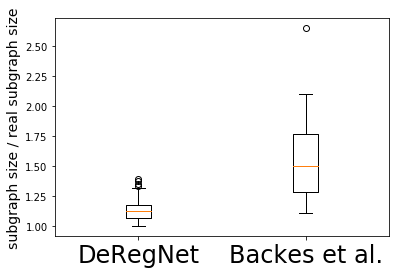

In [196]:
bm.boxplot_size(relative=True, ylabel_fontsize=14,
               tags=['avg_dta', 'abs'], xticks={'avg_dta': 'DeRegNet', 'abs': 'Backes et al.'})

In [197]:
bm.compare(14)

AVG - Generalized Charnes-Cooper
{'subgraph_size': 44, 'success': True, 'hits': 43, 'fp': 2, 'time': 59.84314274787903}
AVG - Dinkelbach
{'subgraph_size': 44, 'success': True, 'hits': 43, 'fp': 2, 'time': 3.6419334411621094}
ABS
{'subgraph_size': 44, 'success': True, 'hits': 43, 'fp': 13, 'time': 25.859723567962646}


In [198]:
bm.compare(-1)

AVG - Generalized Charnes-Cooper
{'subgraph_size': 43, 'success': True, 'hits': 31, 'fp': 5, 'time': 54.71385669708252}
AVG - Dinkelbach
{'subgraph_size': 43, 'success': True, 'hits': 43, 'fp': 5, 'time': 1.3254072666168213}
ABS
{'subgraph_size': 43, 'success': True, 'hits': 43, 'fp': 10, 'time': 21.266461610794067}


In [199]:
bm.compare(54)

AVG - Generalized Charnes-Cooper
{'subgraph_size': 42, 'success': True, 'hits': 41, 'fp': 1, 'time': 54.63715410232544}
AVG - Dinkelbach
{'subgraph_size': 42, 'success': True, 'hits': 41, 'fp': 1, 'time': 1.703505039215088}
ABS
{'subgraph_size': 42, 'success': True, 'hits': 41, 'fp': 13, 'time': 25.188044548034668}


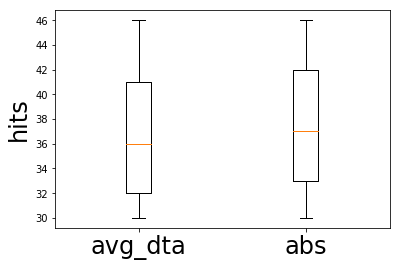

In [200]:
bm.boxplot('hits', tags=['avg_dta', 'abs'])

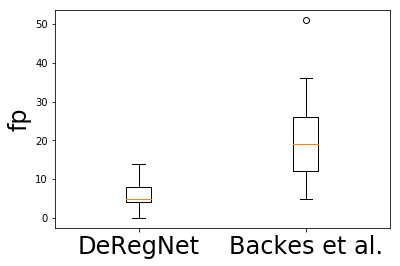

In [189]:
bm.boxplot('fp', tags=['avg_dta', 'abs'], xticks={'avg_dta': 'DeRegNet', 'abs': 'Backes et al.'})

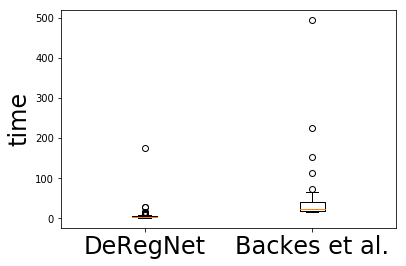

In [190]:
bm.boxplot('time', tags=['avg_dta', 'abs'], xticks={'avg_dta': 'DeRegNet', 'abs': 'Backes et al.'})

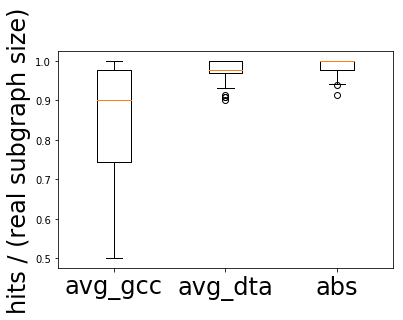

In [191]:
bm.boxplot_proportion('hits')

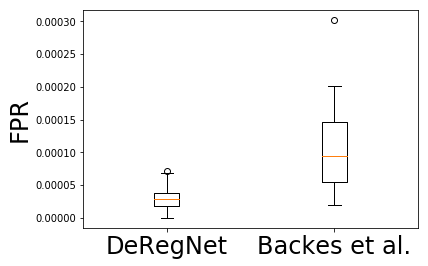

In [192]:
bm.boxplot_fpr(tags=['avg_dta', 'abs'], xticks={'avg_dta': 'DeRegNet', 'abs': 'Backes et al.'}, ylabel='FPR')

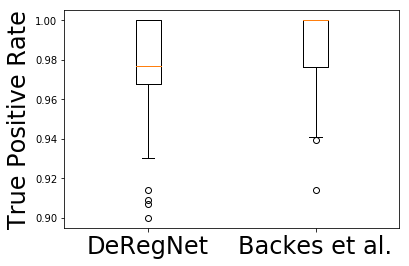

In [193]:
bm.boxplot_tpr(tags=['avg_dta', 'abs'], xticks={'avg_dta': 'DeRegNet', 'abs': 'Backes et al.'})

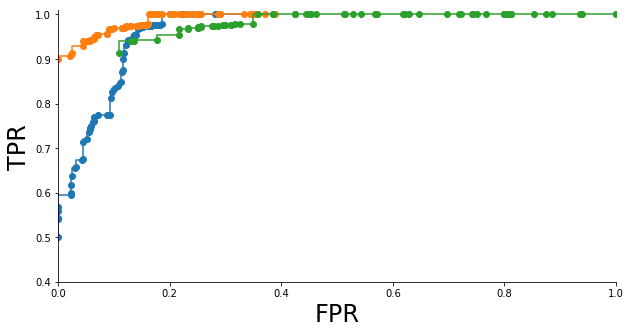

In [169]:
bm.roc(ylim=[0.4,1.01])

In [24]:
bm2 = Benchmark('benchmark.15.25.50.45.0.01.100.600.json')

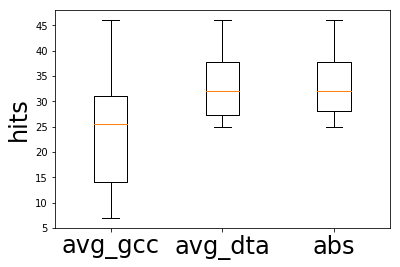

In [25]:
bm2.boxplot('hits')

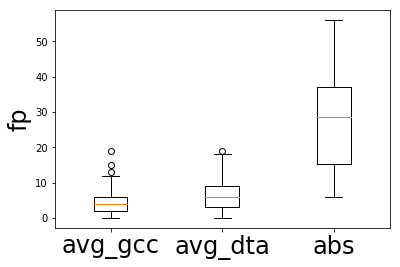

In [26]:
bm2.boxplot('fp')

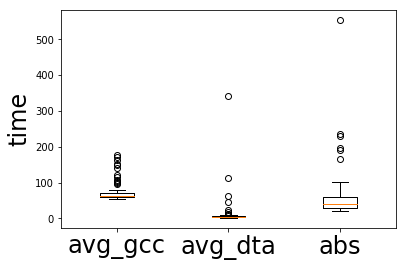

In [27]:
bm2.boxplot('time')

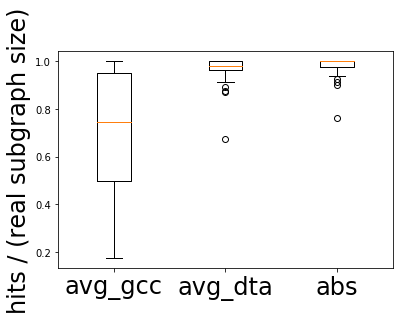

In [28]:
bm2.boxplot_proportion('hits')

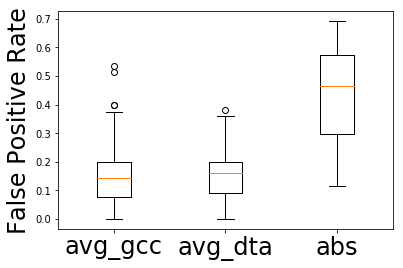

In [29]:
bm2.boxplot_fpr()

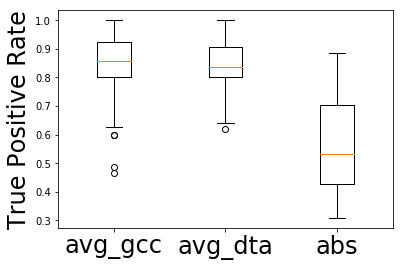

In [30]:
bm2.boxplot_tpr()

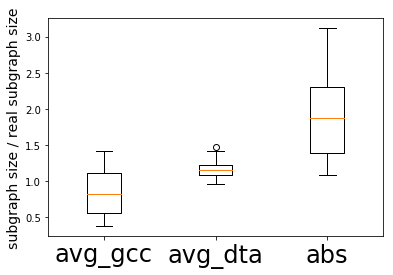

In [31]:
bm2.boxplot_size(relative=True, ylabel_fontsize=14)

In [32]:
bm3 = Benchmark('benchmark.5.5.15.15.0.01.100.600.json')

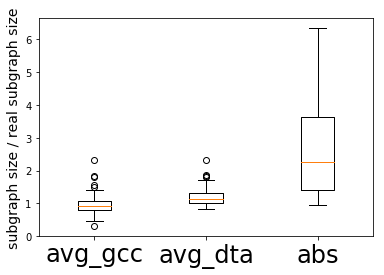

In [33]:
bm3.boxplot_size(relative=True, ylabel_fontsize=14)

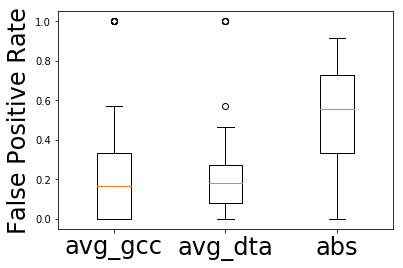

In [34]:
bm3.boxplot_fpr()

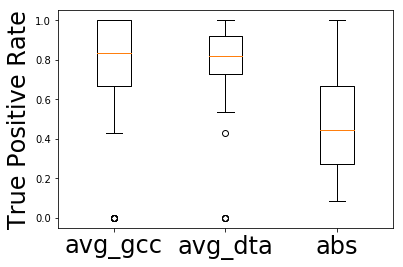

In [35]:
bm3.boxplot_tpr()

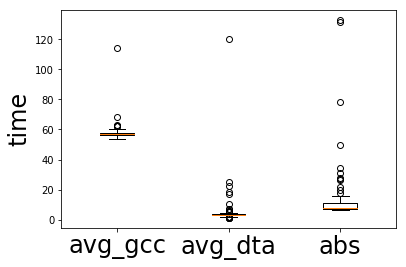

In [36]:
bm3.boxplot('time')